<a href="https://colab.research.google.com/github/Kammarianand/machine_learning_models_projects/blob/main/solarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy import stats
import re
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

In [3]:
import xgboost as xgb
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential

In [56]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [5]:
data = pd.read_csv('SolarPrediction.csv')


In [6]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


**data wrangling**

In [9]:
df = data.copy()

In [10]:
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [11]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [12]:
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [14]:
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [15]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [16]:
features = df.drop('Radiation', axis = 1)
target = df['Radiation']

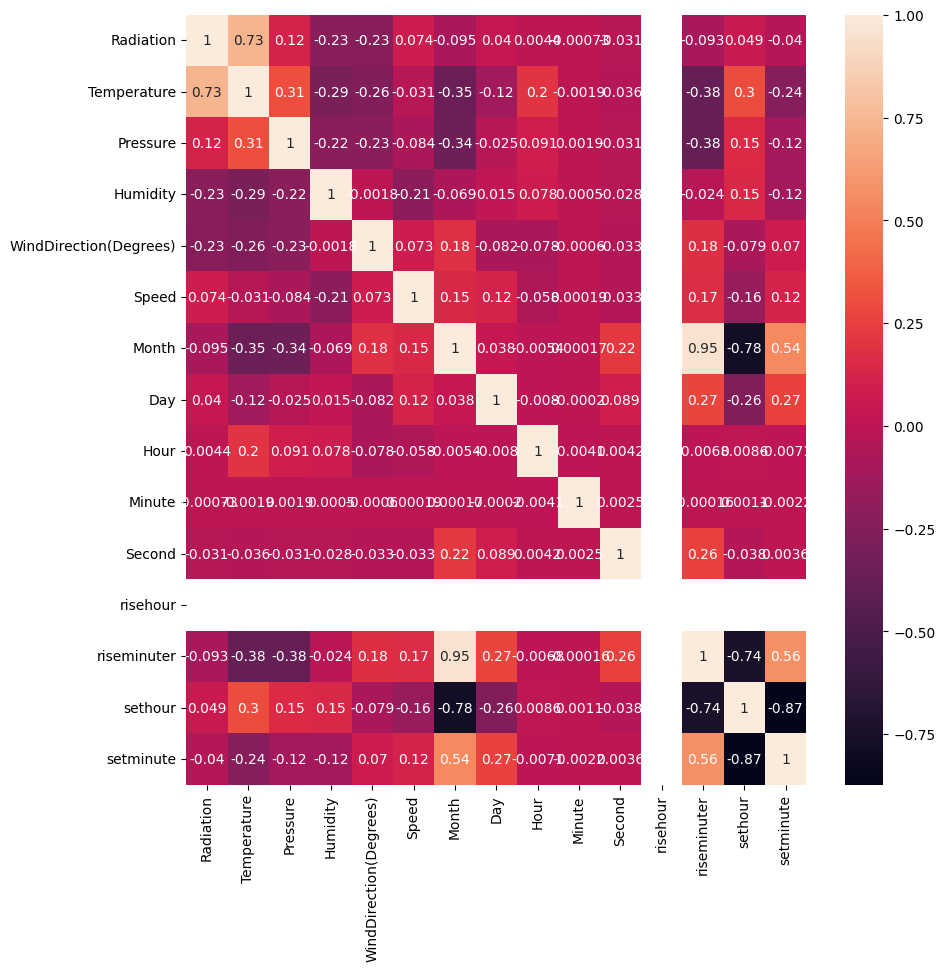

In [18]:
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

feature selection with seleckbest method

In [19]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [20]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [21]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [23]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(features.columns)

In [24]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [25]:
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


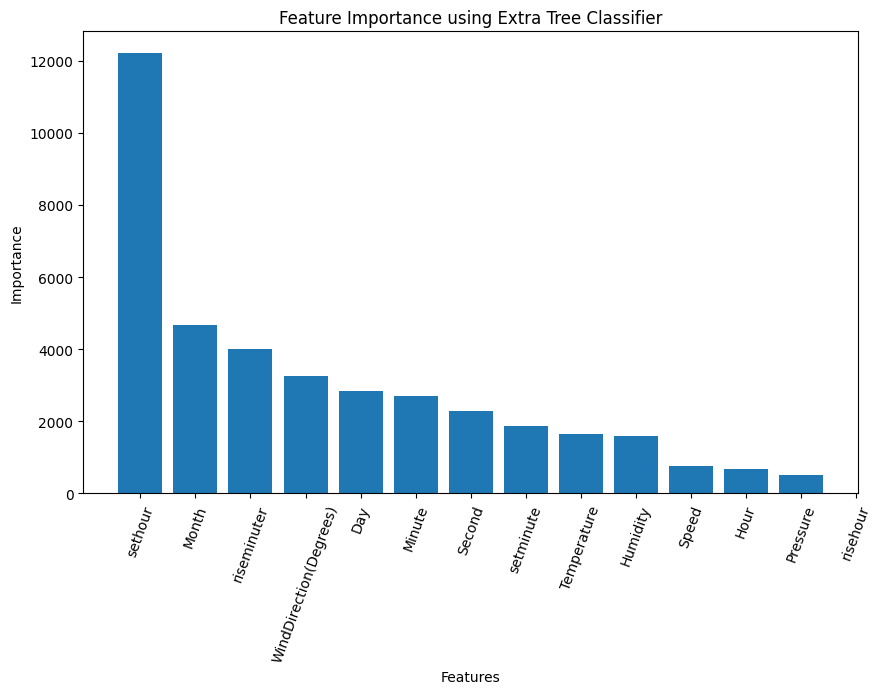

In [26]:
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

**feature engineering**

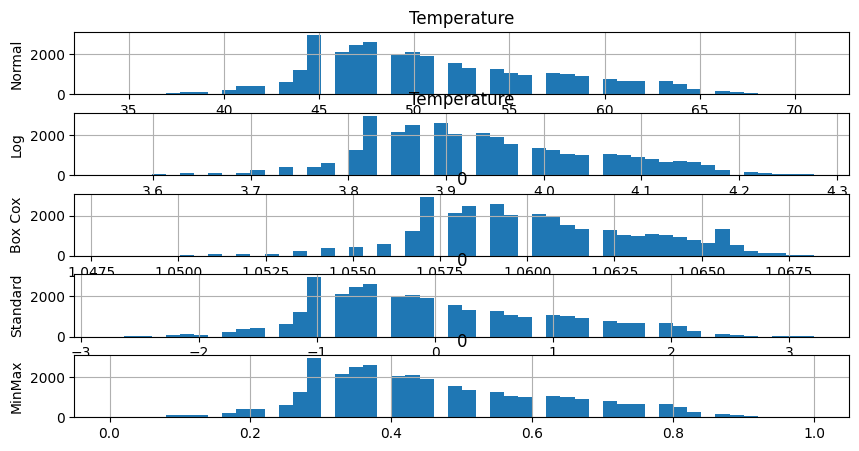

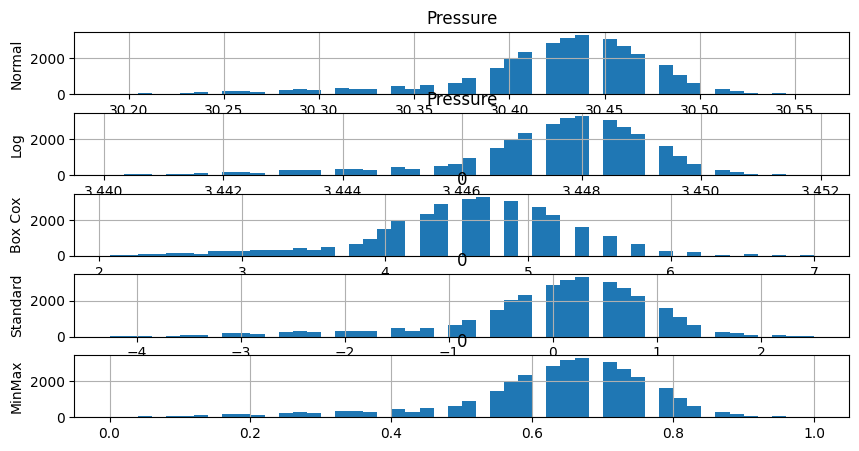

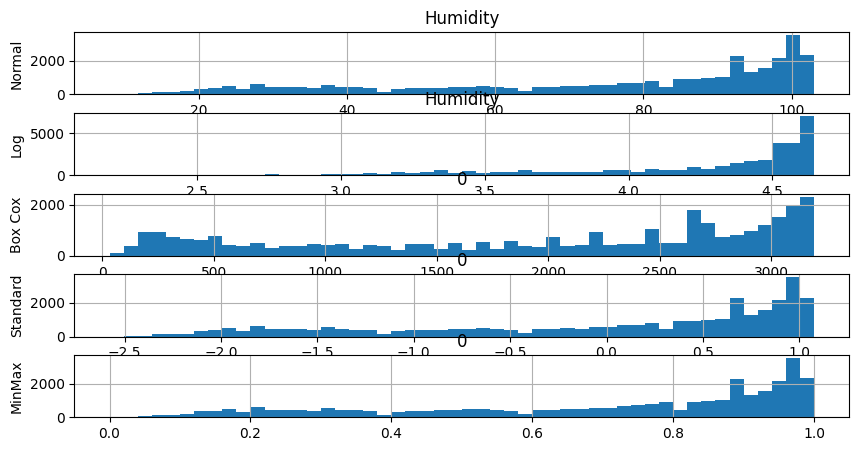

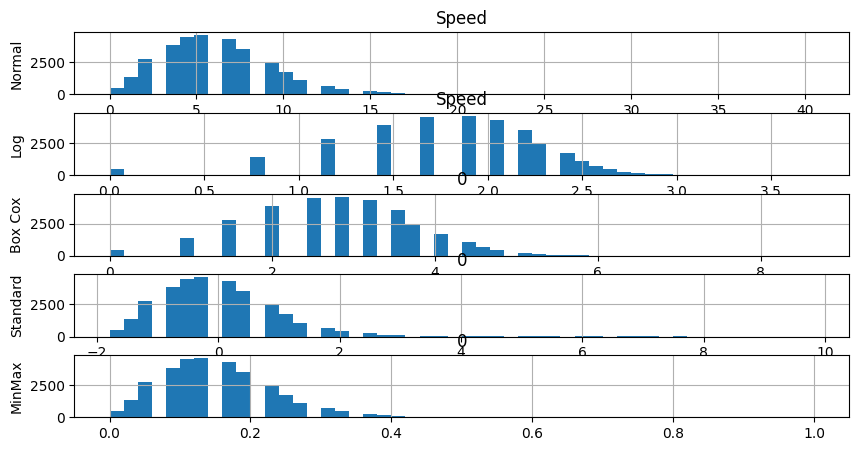

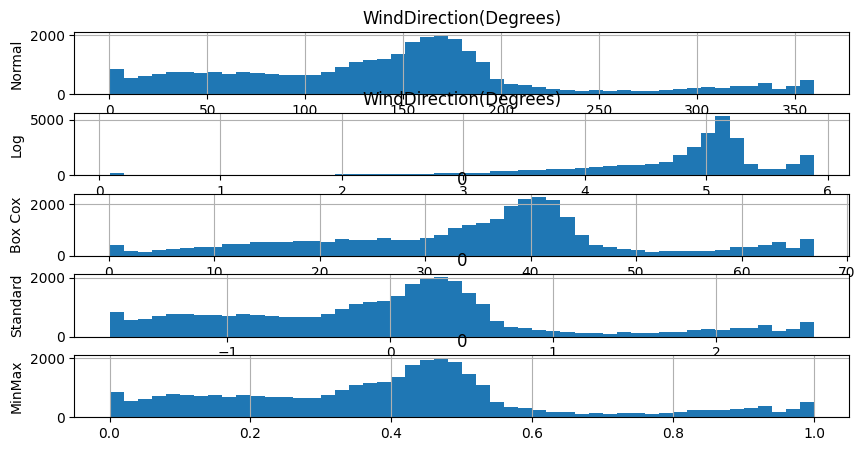

In [27]:
featuresToTransform = ['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']

for i in featuresToTransform:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    pd.DataFrame(features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(features[i]+1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')


In [29]:
transform = {'Temperature' : (features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(features['Humidity']+1)[0],
            'Speed' : (features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    features[i] = transform[i]

In [30]:
features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


In [31]:
# data preparation
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.3)

In [32]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [33]:
from xgboost import XGBRegressor
params = {
    'learning_rate': 0.1,
    'max_depth':8
}
model = XGBRegressor(**params)

In [34]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
y_pred = model.predict(x_test)

In [36]:
rmse = np.sqrt(mean_squared_error(y_pred,y_test))
r2s = r2_score(y_pred,y_test)

In [37]:
print("Model Performance: ")
print(f'RMSE : {rmse}\nr2s : {r2s}')

Model Performance: 
RMSE : 82.21385899479526
r2s : 0.9289382691182541


**using multilayer perceptron**

In [38]:
model = Sequential()
model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1,activation='relu'))

model.compile(metrics='mse',loss='mae',optimizer=Adam(learning_rate=0.001))



In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [40]:
history = model.fit(x_train,y_train,validation_split=0.1,epochs=50,batch_size = 32)

Epoch 1/50
644/644 [==============================] - 7s 8ms/step - loss: 126.2755 - mse: 60769.0117 - val_loss: 78.9455 - val_mse: 23182.2305
Epoch 2/50
644/644 [==============================] - 3s 5ms/step - loss: 87.0609 - mse: 28665.1504 - val_loss: 72.9317 - val_mse: 20851.1465
Epoch 3/50
644/644 [==============================] - 3s 4ms/step - loss: 82.1764 - mse: 25797.4492 - val_loss: 66.8098 - val_mse: 17942.9629
Epoch 4/50
644/644 [==============================] - 3s 5ms/step - loss: 78.3166 - mse: 23740.4824 - val_loss: 63.3624 - val_mse: 16365.0732
Epoch 5/50
644/644 [==============================] - 3s 5ms/step - loss: 75.7010 - mse: 22312.2344 - val_loss: 62.6692 - val_mse: 16295.2520
Epoch 6/50
644/644 [==============================] - 3s 4ms/step - loss: 74.0544 - mse: 21380.0723 - val_loss: 58.2536 - val_mse: 14669.1279
Epoch 7/50
644/644 [==============================] - 3s 4ms/step - loss: 72.9139 - mse: 20866.0215 - val_loss: 57.5397 - val_mse: 14309.4053
Epoch

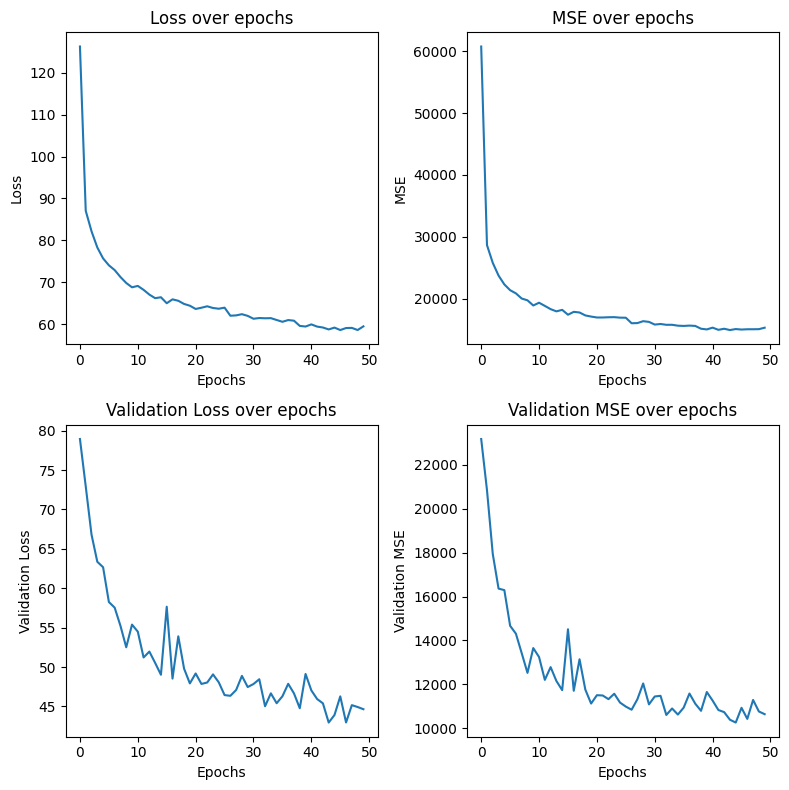

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plotting loss over epochs
if 'loss' in history.history:
    axs[0, 0].plot(history.history['loss'])
    axs[0, 0].set_title('Loss over epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_xlabel('Epochs')

# Plotting mse over epochs
if 'mse' in history.history:
    axs[0, 1].plot(history.history['mse'])
    axs[0, 1].set_title('MSE over epochs')
    axs[0, 1].set_ylabel('MSE')
    axs[0, 1].set_xlabel('Epochs')

# Plotting validation loss over epochs
if 'val_loss' in history.history:
    axs[1, 0].plot(history.history['val_loss'])
    axs[1, 0].set_title('Validation Loss over epochs')
    axs[1, 0].set_ylabel('Validation Loss')
    axs[1, 0].set_xlabel('Epochs')

# Plotting validation mse over epochs
if 'val_mse' in history.history:
    axs[1, 1].plot(history.history['val_mse'])
    axs[1, 1].set_title('Validation MSE over epochs')
    axs[1, 1].set_ylabel('Validation MSE')
    axs[1, 1].set_xlabel('Epochs')

plt.tight_layout()
plt.show()

In [53]:
y_predict = model.predict(x_test)

307/307 [==============================] - 1s 3ms/step


In [58]:
mean_absolute_error(y_predict,y_test)

43.672359308854624